# Reto Deep Learning

Andrea Quiroz A01026486

Esteban Valle A01747146

## Introducción

#### Explicación del problema

### Tenemos que hacer un modelo de red convolucional para clasificar prendas usando la base de ados Fashion MNIST. Este es un problema de clasificación de clases múltiples. Debido a que tenemos las labels en el dataset y con estas vamos a hacer el entrenamiento, es un problema de supervised deep learning (aprendizaje profundo supervisado). Después de explorar la documentación del dataset encontramos que son 10 clases en total. El dataset ya viene dividido en train y test. El train set tiene 60000 entradas mientras que el test set tiene 10000. El dataset en total cuenta con 70000 instancias. Para evitar sesgos a la hora de hacer el model, dividiremos el train set en train y validation, siendo el validation 20% del total del train set. De etsa manera, nos quedan 48000 datos en el train set y 12000 en el validation set.

#### Importar librerías

In [768]:
#For data manipulation and cvisualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#For modeling
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.utils import model_to_dot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#### Desacrgar la base de datos

In [769]:
f_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = f_mnist.load_data()

#### Exploración de la base de datos

In [770]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)


In [771]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [772]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Tenemos diez clases en el dataset. Después de ver la documentación, podemos ver que las etiquetas son las siguientes:


0 - T-Shirt/Top

1 - Trouser

2 - Pullover

3 - Dress

4 - Coat

5 - Sandals

6 - Shirt

7 - Sneaker

8 - Bag

9 - Ankle boots

Separación del train en train y validation

In [773]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True)

In [774]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (48000, 28, 28)
y_train shape: (48000,)


In [775]:
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_val shape: (12000, 28, 28)
y_val shape: (12000,)


In [776]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [777]:
print('Valor mínimo de X_train:', X_train.min())
print('Valor máximo de X_train:', X_train.max())
print('Valor mínimo de X_val:', X_val.min())
print('Valor máximo de X_val:', X_val.max())

Valor mínimo de X_train: 0
Valor máximo de X_train: 255
Valor mínimo de X_val: 0
Valor máximo de X_val: 255


In [778]:
# Reescalar imágenes de 0-255 a 0-1 para normalizarlas
# X_train = X_train / 255.0
# X_val = X_val / 255.0

### Data Augmentation

In [779]:
train_img_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

val_img_generator = ImageDataGenerator(rescale=1./255)

test_img_generator = ImageDataGenerator()

In [780]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [781]:
train_img_generator.fit(X_train)
val_img_generator.fit(X_val)
test_img_generator.fit(X_test)

In [782]:
batch_size = 32
train = train_img_generator.flow(X_train, y_train, batch_size=batch_size)
val = val_img_generator.flow(X_val, y_val, batch_size=batch_size)
test = test_img_generator.flow(X_test, y_test, batch_size=1)

### Data Vusialization

In [783]:
def visualize_dataset(n,x,y):
    plt.figure(figsize=(10,10))
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=plt.get_cmap('gray'))
        plt.xlabel(y[i])
    plt.show()

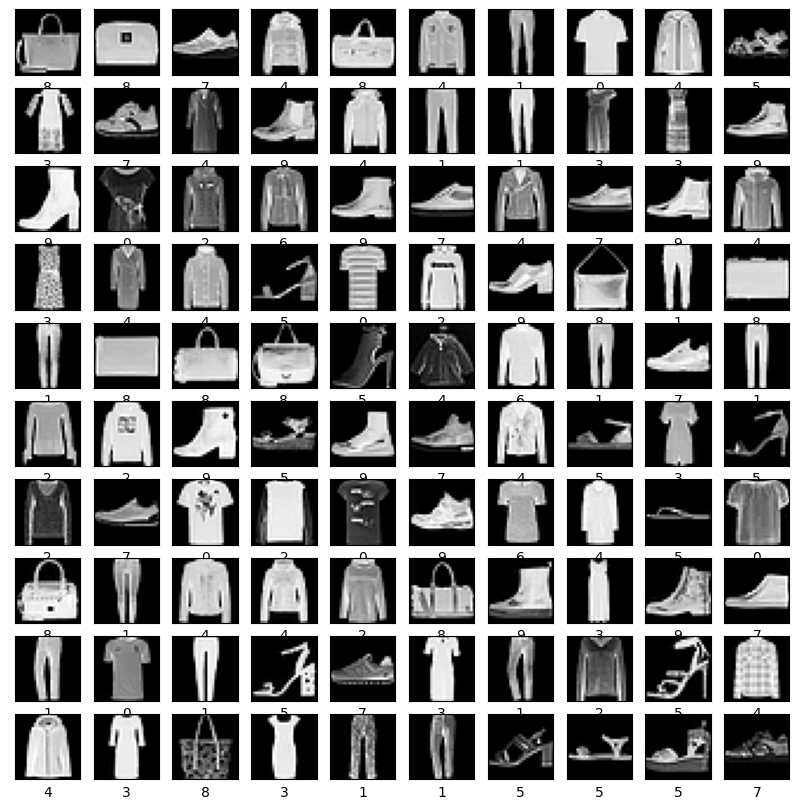

In [784]:
visualize_dataset(10, X_val, y_val)

In [785]:
def visualize_labels(y,visualize=False):
    unique, counts = np.unique(y, return_counts=True) # Encuentra los elementos únicos de un array
    print('Clases: ', unique)
    print('Número de instancias por clase', counts)

    if visualize == True:
        plt.figure(figsize=(11,5))
        plt.bar(unique,counts, color = (0.3,0.1,0.4,0.6))
        plt.xlabel('Clases')
        plt.ylabel('Frecuencia')
        plt.xticks(unique)

        for i, v in enumerate(counts):
            plt.text(i-0.25, v+10, str(v), color = 'blue')
        plt.show()


Clases:  [0 1 2 3 4 5 6 7 8 9]
Número de instancias por clase [4798 4781 4795 4816 4798 4789 4782 4841 4803 4797]


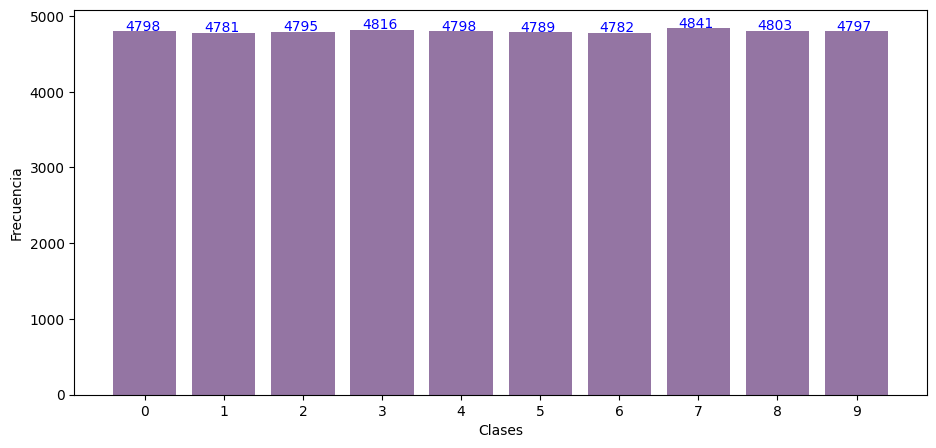

In [786]:
visualize_labels(y_train, True)

## Modelo 1

Explicación de cada capa y como se hace el cálculo de los parámetros entrenables

#### Definir

In [819]:
model1 = Sequential([
    Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (28 ,28 ,1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.05),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    Dense(10, activation='softmax') 
])

#### Compilar

In [820]:
model1.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Entrenar/Ajustar

In [821]:
history1 = model1.fit(X_train, y_train,
                  batch_size=128,
                  epochs=20,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/20


375/375 [==============================] - 11s 27ms/step - loss: 0.7259 - accuracy: 0.7658 - val_loss: 0.4545 - val_accuracy: 0.8331
Epoch 2/20
375/375 [==============================] - 10s 27ms/step - loss: 0.3922 - accuracy: 0.8638 - val_loss: 0.3423 - val_accuracy: 0.8762
Epoch 3/20
375/375 [==============================] - 11s 30ms/step - loss: 0.3330 - accuracy: 0.8831 - val_loss: 0.3082 - val_accuracy: 0.8852
Epoch 4/20
375/375 [==============================] - 11s 30ms/step - loss: 0.2965 - accuracy: 0.8927 - val_loss: 0.3006 - val_accuracy: 0.8879
Epoch 5/20
375/375 [==============================] - 11s 29ms/step - loss: 0.2742 - accuracy: 0.9027 - val_loss: 0.2976 - val_accuracy: 0.8921
Epoch 6/20
375/375 [==============================] - 10s 27ms/step - loss: 0.2561 - accuracy: 0.9065 - val_loss: 0.2805 - val_accuracy: 0.8963
Epoch 7/20
375/375 [==============================] - 10s 27ms/step - loss: 0.2472 - accuracy: 0.9102 - val_loss: 0.2659 - val_accuracy: 0.9040
Epo

### Gráficas

#### Loss & Accuracy

/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPy

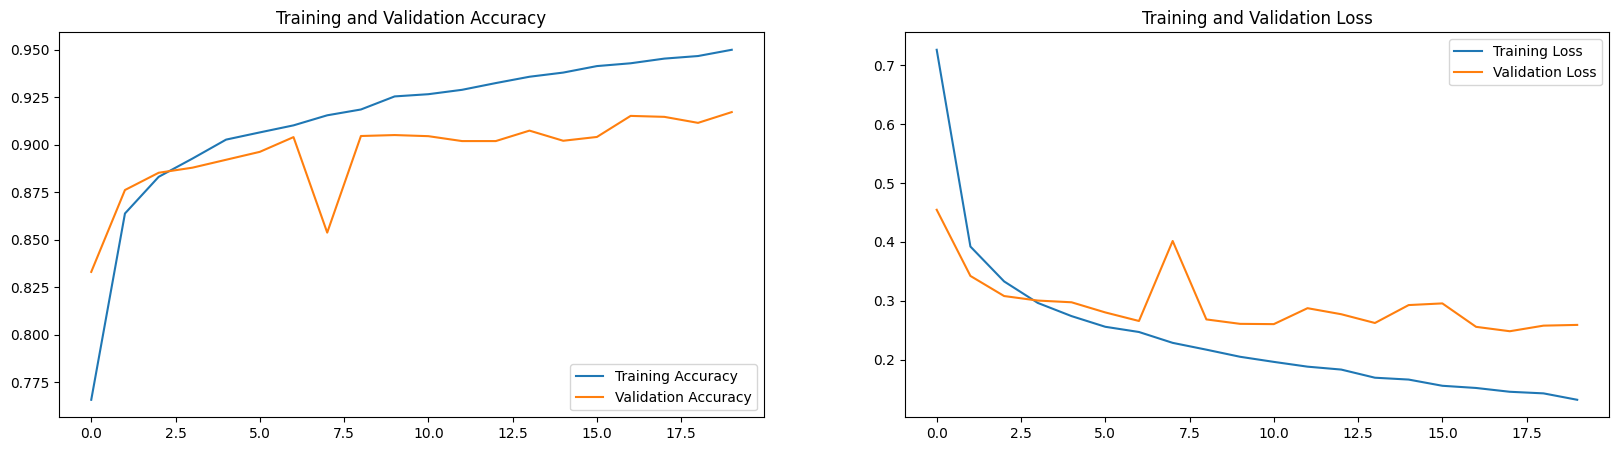

In [822]:
# Visualizar gráficas de aprendizaje
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = np.arange(len(history1.history['loss']))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig('./foo.png')
plt.show()

## Modelo 2

Explicación de cada capa y como se hace el cálculo de los parámetros entrenables

#### Definir

#### Compilar

### Entrenar

#### Ajustar

### Gráficas

#### Evaluar

#### Accuracy

#### Loss

## Comparación

Explicar diferencia entre los modelos y justificar la respuesta.

Exzplicar cual es el mejor. Seleccionar la mejor red y jsutificar respuesta.

## Evaluación

In [ ]:
test_loss, test_acc = model12.evaluate(X_test,y_test , verbose=0)
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')

Con el modelo ???, el cual cosnideramos es el mejor de los dos realizados, vamos a usar el conjunto de "test"  y mostrar el desempeño real de nuestra red convolucional.

## Predicción

In [ ]:
y_pred = model12.predict(X_test)

In [ ]:
print(y_pred[1])

In [ ]:
# Suma de las salidas de softmax
print(np.sum(y_pred[1]))

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_pred

In [ ]:
print(y_pred[1])

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True,cbar=False,fmt='d')
plt.xlabel("Predicted", fontsize = 18)
plt.ylabel("True", fontsize = 18)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
def plot_prediction(index):
    print('Valor real: ',y_test[index])
    print('Predicción: ',y_pred[index])
    plt.figure(figsize=(6,3))
    plt.imshow(x_test[index], cmap='gray')
    plt.axis('off')
    plt.show()


In [ ]:
i = 50
plot_prediction(i)

## Conclusiones

#### Andrea

Posibles mejoras. Actividades realizadas.

#### Esteban

Posibles mejoras. Actividades realizadas.

## Referencias

Dataset:

Han Xiao, Kashif Rasul, & Roland Vollgraf (2017). Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. CoRR, abs/1708.07747. Retrieved from: http://arxiv.org/abs/1708.07747

 

Data Augmentation Reference:

Foucardm. (2020, 9 agosto). Data augmentation on the MNIST dataset. Kaggle. https://www.kaggle.com/code/foucardm/data-augmentation-on-the-mnist-dataset/notebook

 

CNN with Tensorflow:

https://colab.research.google.com/drive/1sWhP2AnjsvEdD1mLbusXEeb2sD4H1mzu#scrollTo=HGvyJbZ8Y6jA